# Notebook 2 – Feature Engineering & ML Modeling

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('TCS_stock_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA50,MA200,Daily_return
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,NaN,NaN,NaN
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,NaN,NaN,-1.353915
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,NaN,NaN,-6.894351
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,NaN,NaN,0.000000
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,NaN,NaN,-0.239988


# Feature engineering

Add rolling means, EMAs, lags, and date parts.

In [19]:

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek


df['Prev_Close'] = df['Close'].shift(1)
df['Prev_Volume'] = df['Volume'].shift(1)


df['Rolling_7']  = df['Close'].rolling(window=7).mean()
df['Rolling_30'] = df['Close'].rolling(window=30).mean()
df['Rolling_STD_7'] = df['Close'].rolling(window=7).std()


df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()


df['MACD'] = df['EMA_12'] - df['EMA_26']


df['Daily_Return'] = df['Close'].pct_change()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("After feature engineering:", df.shape)
df.head()


After feature engineering: (4264, 23)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA50,MA200,...,DayOfWeek,Prev_Close,Prev_Volume,Rolling_7,Rolling_30,Rolling_STD_7,EMA_12,EMA_26,MACD,Daily_Return
0,2004-06-21,66.919920,68.407029,64.540547,65.451401,49328,0.0,0.0,53.539858,38.361673,...,0,66.157806,91440.0,65.416892,63.491536,2.020764,63.806922,61.227211,2.579711,-0.010678
1,2004-06-22,65.432855,65.618744,63.573967,63.927155,20064,0.0,0.0,54.208315,38.533714,...,1,65.451401,49328.0,64.605620,63.012254,0.872162,63.825419,61.427207,2.398212,-0.023288
2,2004-06-23,64.596334,65.061056,61.584935,62.681683,22912,0.0,0.0,54.837176,38.701525,...,2,63.927155,20064.0,64.387866,62.661544,1.138266,63.649460,61.520131,2.129329,-0.019483
3,2004-06-24,63.192893,64.317518,61.919554,63.722672,21592,0.0,0.0,55.496152,38.884579,...,3,62.681683,22912.0,64.269697,62.410594,1.161349,63.660723,61.683282,1.977441,0.016608
4,2004-06-25,63.202185,65.061073,63.202185,63.722672,60280,0.0,0.0,56.147134,39.067632,...,4,63.722672,21592.0,64.247132,62.327873,1.171658,63.670254,61.834348,1.835905,0.000000


# Select features and target

In [20]:
feature_cols = [
    'Open','High','Low','Volume','Prev_Close','Prev_Volume',
    'Rolling_7','Rolling_30','Rolling_STD_7',
    'EMA_12','EMA_26','MACD','Daily_Return',
    'Year','Month','DayOfWeek'
]
target_col = 'Close'

X = df[feature_cols]
y = df[target_col]


# Train/test split (chronological)

In [21]:
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (3411, 16) Test: (853, 16)


# Linear Regression model

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mse_lr  = mean_squared_error(y_test, y_pred_lr)
mae_lr  = mean_absolute_error(y_test, y_pred_lr)
r2_lr   = r2_score(y_test, y_pred_lr)

print(f"Linear Regression → MSE:{mse_lr:.2f}, MAE:{mae_lr:.2f}, R²:{r2_lr:.4f}")

joblib.dump(lr, 'tcs_linear_regression.pkl')


Linear Regression → MSE:219.91, MAE:10.84, R²:0.9993


['tcs_linear_regression.pkl']

# Random Forest model

In [23]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf  = mean_squared_error(y_test, y_pred_rf)
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

print(f"Random Forest → MSE:{mse_rf:.2f}, MAE:{mae_rf:.2f}, R²:{r2_rf:.4f}")

# Save model
joblib.dump(rf, 'tcs_random_forest.pkl')


Random Forest → MSE:1039723.14, MAE:840.56, R²:-2.1175


['tcs_random_forest.pkl']

# Compare models

In [24]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MSE': [mse_lr, mse_rf],
    'MAE': [mae_lr, mae_rf],
    'R2':  [r2_lr, r2_rf]
})
results


,Model,MSE,MAE,R2
0,Linear Regression,2.199086e+02,10.836356,0.999341
1,Random Forest,1.039723e+06,840.557000,-2.117456


# Visualize actual vs predicted prices

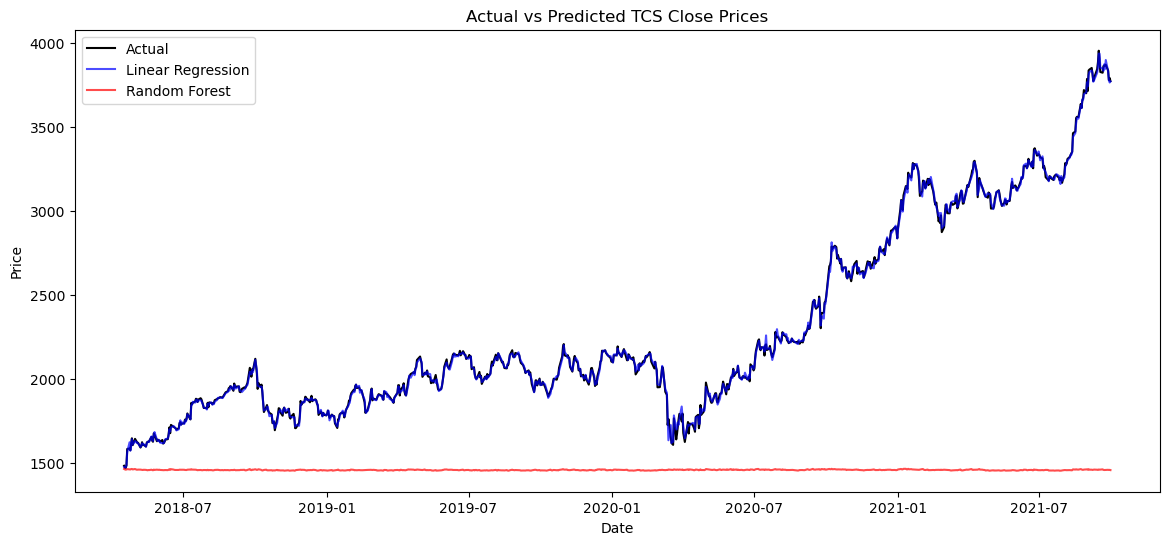

In [25]:
test_dates = df['Date'].iloc[split:]

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test, label='Actual', color='black')
plt.plot(test_dates, y_pred_lr, label='Linear Regression', color='blue', alpha=0.7)
plt.plot(test_dates, y_pred_rf, label='Random Forest', color='red', alpha=0.7)
plt.title('Actual vs Predicted TCS Close Prices')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend()
plt.show()


# Feature importance (Random Forest)

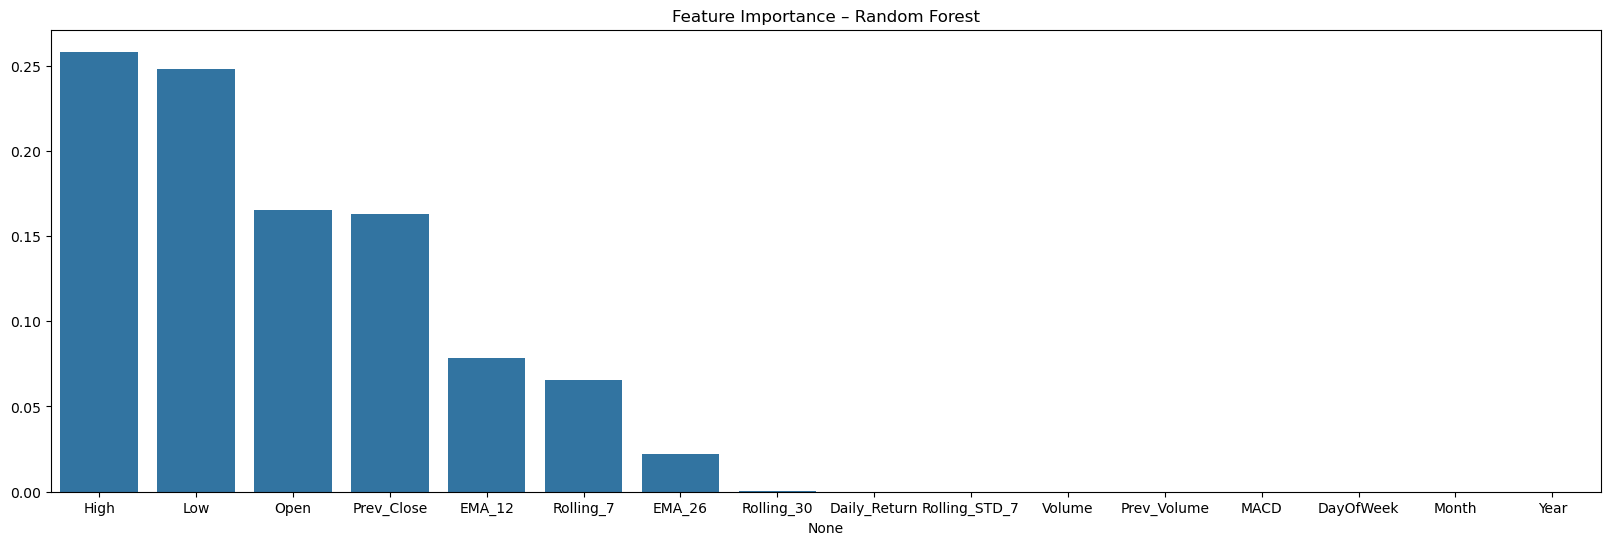

In [26]:
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(20,6))
sns.barplot(x=importances.index, y=importances.values)
plt.title('Feature Importance – Random Forest')
plt.show()


# Save predictions for future use

In [27]:
pred_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close': y_test.values,
    'Predicted_LR': y_pred_lr,
    'Predicted_RF': y_pred_rf
})
pred_df.to_csv('TCS_predictions_baseline.csv', index=False)
print(" Predictions saved → data/TCS_predictions_baseline.csv")


 Predictions saved → data/TCS_predictions_baseline.csv


# Output Summary

Clean engineered dataset with lags & moving averages

Two ML models (Linear Regression, Random Forest)

Metrics (MSE, MAE, R²)

Actual vs Predicted visuals

Saved models & predictions